# Your first neural network

In this project, you'll build your first neural network and use it to predict daily bike rental ridership. We've provided some of the code, but left the implementation of the neural network up to you (for the most part). After you've submitted this project, feel free to explore the data and the model more.



In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. Below, we've written the code to load and prepare the data. You'll learn more about this soon!

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [3]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. (Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days.) You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. You'll be trying to capture all this with your model.

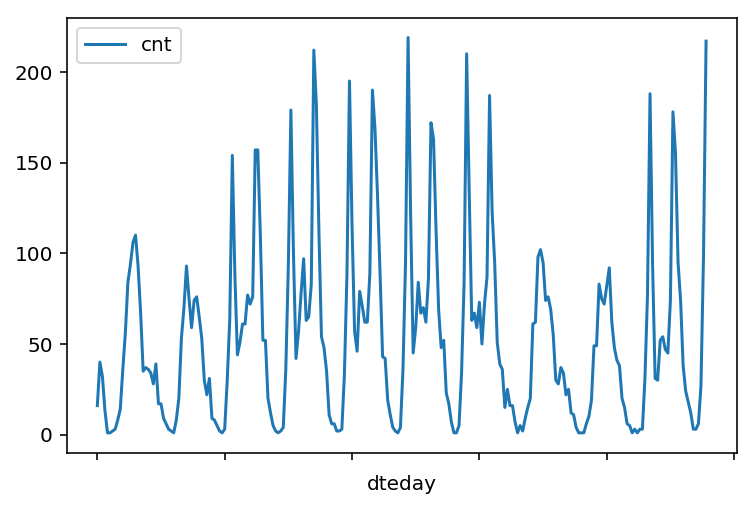

In [4]:
rides[:24*10].plot(x='dteday', y='cnt')

### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [5]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [6]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

We'll save the data for the last approximately 21 days to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [7]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [8]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Time to build the network

Below you'll build your network. We've built out the structure. You'll implement both the forward pass and backwards pass through the network. You'll also set the hyperparameters: the learning rate, the number of hidden units, and the number of training passes.

<img src="assets/neural_network.png" width=300px>

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*.

> **Hint:** You'll need the derivative of the output activation function ($f(x) = x$) for the backpropagation implementation. If you aren't familiar with calculus, this function is equivalent to the equation $y = x$. What is the slope of that equation? That is the derivative of $f(x)$.

Below, you have these tasks:
1. Implement the sigmoid function to use as the activation function. Set `self.activation_function` in `__init__` to your sigmoid function.
2. Implement the forward pass in the `train` method.
3. Implement the backpropagation algorithm in the `train` method, including calculating the output error.
4. Implement the forward pass in the `run` method.
  

In [32]:
#############
# In the my_answers.py file, fill out the TODO sections as specified
#############

from my_answers import NeuralNetwork

In [33]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Unit tests

Run these unit tests to check the correctness of your network implementation. This will help you be sure your network was implemented correctly befor you starting trying to train it. These tests must all be successful to pass the project.

In [34]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....

[[0.09998924]]



----------------------------------------------------------------------
Ran 5 tests in 0.009s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## Training the network

Here you'll set the hyperparameters for the network. The strategy here is to find hyperparameters such that the error on the training set is low, but you're not overfitting to the data. If you train the network too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops.

You'll also be using a method know as Stochastic Gradient Descent (SGD) to train the network. The idea is that for each training pass, you grab a random sample of the data instead of using the whole data set. You use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network more efficiently. You'll learn more about SGD later.

### Choose the number of iterations
This is the number of batches of samples from the training data we'll use to train the network. The more iterations you use, the better the model will fit the data. However, this process can have sharply diminishing returns and can waste computational resources if you use too many iterations.  You want to find a number here where the network has a low training loss, and the validation loss is at a minimum. The ideal number of iterations would be a level that stops shortly after the validation loss is no longer decreasing.

### Choose the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. Normally a good choice to start at is 0.1; however, if you effectively divide the learning rate by n_records, try starting out with a learning rate of 1. In either case, if the network has problems fitting the data, try reducing the learning rate. Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge.

### Choose the number of hidden nodes
In a model where all the weights are optimized, the more hidden nodes you have, the more accurate the predictions of the model will be.  (A fully optimized model could have weights of zero, after all.) However, the more hidden nodes you have, the harder it will be to optimize the weights of the model, and the more likely it will be that suboptimal weights will lead to overfitting. With overfitting, the model will memorize the training data instead of learning the true pattern, and won't generalize well to unseen data.  

Try a few different numbers and see how it affects the performance. You can look at the losses dictionary for a metric of the network performance. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units you choose.  You'll generally find that the best number of hidden nodes to use ends up being between the number of input and output nodes.

In [35]:
import sys

####################
### Set the hyperparameters in you myanswers.py file ###
####################

from my_answers import iterations, learning_rate, hidden_nodes, output_nodes


N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

[[-0.2865047 ]
 [-0.21894986]
 [-0.28844059]
 ...
 [-0.17621388]
 [-0.26275489]
 [-0.2741248 ]]
[[-0.32507722]
 [-0.29055016]
 [-0.31765857]
 ...
 [-0.30329555]
 [-0.28848846]
 [-0.24523774]]
Progress: 0.0% ... Training loss: 1.083 ... Validation loss: 1.635[[-0.14261037]
 [-0.07717709]
 [-0.1433938 ]
 ...
 [-0.0322092 ]
 [-0.11672233]
 [-0.12431533]]
[[-0.16933616]
 [-0.13847454]
 [-0.16398994]
 ...
 [-0.14883817]
 [-0.13815986]
 [-0.10759356]]
Progress: 0.1% ... Training loss: 1.007 ... Validation loss: 1.486[[-0.09426491]
 [-0.02954878]
 [-0.09443097]
 ...
 [ 0.01846994]
 [-0.06554391]
 [-0.06930384]]
[[-0.11133523]
 [-0.07744771]
 [-0.10121406]
 ...
 [-0.08941363]
 [-0.08310933]
 [-0.0594247 ]]
Progress: 0.2% ... Training loss: 0.985 ... Validation loss: 1.437[[-0.06896486]
 [-0.00477355]
 [-0.06895637]
 ...
 [ 0.04497122]
 [-0.03873904]
 [-0.03998891]]
[[-0.07950171]
 [-0.04403845]
 [-0.06686704]
 ...
 [-0.05742136]
 [-0.05364882]
 [-0.0343543 ]]
Progress: 0.3% ... Training loss: 

/home/leovargas/.conda/envs/meuAmbiente/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


[[-0.03959108]
 [ 0.02312896]
 [-0.03881213]
 ...
 [ 0.09207774]
 [ 0.00969216]
 [ 0.01768952]]
[[-0.01398374]
 [ 0.037212  ]
 [ 0.02010021]
 ...
 [ 0.01395121]
 [ 0.00396282]
 [ 0.01034279]]
Progress: 0.7% ... Training loss: 0.949 ... Validation loss: 1.356[[-0.12158947]
 [-0.05870802]
 [-0.12122816]
 ...
 [ 0.01825864]
 [-0.06523489]
 [-0.05493354]]
[[-0.08687489]
 [-0.02578445]
 [-0.04130338]
 ...
 [-0.05573067]
 [-0.06925438]
 [-0.06046314]]
Progress: 0.8% ... Training loss: 0.945 ... Validation loss: 1.392[[-0.13364464]
 [-0.07092778]
 [-0.13321719]
 ...
 [ 0.01064952]
 [-0.0730433 ]
 [-0.0600021 ]]
[[-0.0904474 ]
 [-0.02407887]
 [-0.03822165]
 ...
 [-0.05717724]
 [-0.07391302]
 [-0.06767284]]
Progress: 0.9% ... Training loss: 0.939 ... Validation loss: 1.389[[-0.15583942]
 [-0.09280249]
 [-0.15554154]
 ...
 [-0.00594262]
 [-0.08982245]
 [-0.0741624 ]]
[[-0.10443363]
 [-0.03420979]
 [-0.04763712]
 ...
 [-0.07006054]
 [-0.08926172]
 [-0.0841093 ]]
Progress: 1.0% ... Training loss: 

Progress: 3.8% ... Training loss: 0.798 ... Validation loss: 1.277[[-0.38760794]
 [-0.32257259]
 [-0.38683893]
 ...
 [-0.09686219]
 [-0.18544517]
 [-0.08673909]]
[[-0.07766988]
 [ 0.11885589]
 [ 0.14081082]
 ...
 [-0.00196293]
 [-0.11220946]
 [-0.18162961]]
Progress: 3.9% ... Training loss: 0.795 ... Validation loss: 1.267[[-0.39355264]
 [-0.32839961]
 [-0.39270705]
 ...
 [-0.09710899]
 [-0.18607858]
 [-0.08418065]]
[[-0.07366804]
 [ 0.12823097]
 [ 0.15129395]
 ...
 [ 0.00448446]
 [-0.1097522 ]
 [-0.18236986]]
Progress: 4.0% ... Training loss: 0.790 ... Validation loss: 1.261[[-0.365592  ]
 [-0.30093444]
 [-0.36461117]
 ...
 [-0.06923635]
 [-0.15801258]
 [-0.05342791]]
[[-0.04127204]
 [ 0.160703  ]
 [ 0.184353  ]
 ...
 [ 0.03739814]
 [-0.0791737 ]
 [-0.1556986 ]]
Progress: 4.1% ... Training loss: 0.789 ... Validation loss: 1.239[[-0.39644695]
 [-0.33136952]
 [-0.39554539]
 ...
 [-0.0949887 ]
 [-0.1839324 ]
 [-0.07674741]]
[[-0.06374324]
 [ 0.14388248]
 [ 0.16848832]
 ...
 [ 0.01678338]

Progress: 7.0% ... Training loss: 0.707 ... Validation loss: 1.214[[-0.65339499]
 [-0.58562851]
 [-0.65496084]
 ...
 [-0.200722  ]
 [-0.29563028]
 [-0.12588163]]
[[-0.07407682]
 [ 0.2285908 ]
 [ 0.2769385 ]
 ...
 [ 0.02682551]
 [-0.16883178]
 [-0.29568056]]
Progress: 7.1% ... Training loss: 0.706 ... Validation loss: 1.188[[-0.64156672]
 [-0.57327531]
 [-0.64233201]
 ...
 [-0.18504087]
 [-0.27982815]
 [-0.10733848]]
[[-0.05274723]
 [ 0.25591645]
 [ 0.30594611]
 ...
 [ 0.04945314]
 [-0.15002767]
 [-0.28152507]]
Progress: 7.2% ... Training loss: 0.704 ... Validation loss: 1.170[[-0.64582784]
 [-0.57765815]
 [-0.64694475]
 ...
 [-0.18299924]
 [-0.27801455]
 [-0.10610935]]
[[-0.05101642]
 [ 0.25652182]
 [ 0.30651432]
 ...
 [ 0.04900404]
 [-0.15156738]
 [-0.28154361]]
Progress: 7.3% ... Training loss: 0.703 ... Validation loss: 1.169[[-0.71348953]
 [-0.64434601]
 [-0.71463978]
 ...
 [-0.24565607]
 [-0.34105265]
 [-0.16879611]]
[[-0.11452129]
 [ 0.19838872]
 [ 0.24894081]
 ...
 [-0.0144888 ]

Progress: 10.2% ... Training loss: 0.662 ... Validation loss: 1.145[[-0.88299928]
 [-0.81327146]
 [-0.88726242]
 ...
 [-0.31028955]
 [-0.40650696]
 [-0.19539991]]
[[-0.11152109]
 [ 0.26499944]
 [ 0.33165041]
 ...
 [ 0.00353929]
 [-0.25698891]
 [-0.41047193]]
Progress: 10.3% ... Training loss: 0.661 ... Validation loss: 1.161[[-0.89192843]
 [-0.82253874]
 [-0.89620193]
 ...
 [-0.31543013]
 [-0.41130841]
 [-0.19955322]]
[[-0.11384977]
 [ 0.26418154]
 [ 0.33121813]
 ...
 [ 0.00180628]
 [-0.25968157]
 [-0.41365132]]
Progress: 10.4% ... Training loss: 0.661 ... Validation loss: 1.163[[-0.91055942]
 [-0.84093898]
 [-0.91478268]
 ...
 [-0.33084849]
 [-0.42680717]
 [-0.21454956]]
[[-0.12806201]
 [ 0.25348116]
 [ 0.32141256]
 ...
 [-0.01081744]
 [-0.27454506]
 [-0.42832644]]
Progress: 10.5% ... Training loss: 0.660 ... Validation loss: 1.171[[-0.88496566]
 [-0.81483019]
 [-0.88836333]
 ...
 [-0.30481593]
 [-0.40049835]
 [-0.18621534]]
[[-0.09763787]
 [ 0.2856471 ]
 [ 0.35440627]
 ...
 [ 0.02051

Progress: 13.4% ... Training loss: 0.637 ... Validation loss: 1.075[[-0.97608553]
 [-0.90442941]
 [-0.97906933]
 ...
 [-0.31783399]
 [-0.40926124]
 [-0.17176009]]
[[-0.05578723]
 [ 0.35734204]
 [ 0.43183169]
 ...
 [ 0.06518963]
 [-0.24040026]
 [-0.41086632]]
Progress: 13.5% ... Training loss: 0.635 ... Validation loss: 1.092[[-0.99884055]
 [-0.92690538]
 [-1.00206812]
 ...
 [-0.33978317]
 [-0.43125044]
 [-0.19303626]]
[[-0.07629879]
 [ 0.33957455]
 [ 0.41463266]
 ...
 [ 0.04501921]
 [-0.26161679]
 [-0.43196774]]
Progress: 13.6% ... Training loss: 0.634 ... Validation loss: 1.104[[-1.01436656]
 [-0.94232145]
 [-1.01801802]
 ...
 [-0.35266071]
 [-0.44389133]
 [-0.20954366]]
[[-0.09294166]
 [ 0.32031685]
 [ 0.39420521]
 ...
 [ 0.02672611]
 [-0.27817804]
 [-0.4435697 ]]
Progress: 13.7% ... Training loss: 0.634 ... Validation loss: 1.116[[-0.99767097]
 [-0.92609651]
 [-1.00153048]
 ...
 [-0.33046165]
 [-0.42181028]
 [-0.1865796 ]]
[[-0.06939374]
 [ 0.34370609]
 [ 0.41761167]
 ...
 [ 0.04922

Progress: 16.6% ... Training loss: 0.614 ... Validation loss: 1.061[[-1.08300948]
 [-1.01014091]
 [-1.08693427]
 ...
 [-0.34247112]
 [-0.42765544]
 [-0.17629983]]
[[-0.03729605]
 [ 0.39263881]
 [ 0.46725832]
 ...
 [ 0.07152331]
 [-0.2663569 ]
 [-0.43418575]]
Progress: 16.7% ... Training loss: 0.613 ... Validation loss: 1.058[[-1.07029535]
 [-0.99757243]
 [-1.07398558]
 ...
 [-0.32307117]
 [-0.40794101]
 [-0.15647643]]
[[-0.01364682]
 [ 0.41747434]
 [ 0.49314764]
 ...
 [ 0.09459072]
 [-0.24599746]
 [-0.4156472 ]]
Progress: 16.8% ... Training loss: 0.613 ... Validation loss: 1.043[[-1.06648972]
 [-0.99343049]
 [-1.06983702]
 ...
 [-0.31688782]
 [-0.40100811]
 [-0.14683179]]
[[-0.00258328]
 [ 0.428858  ]
 [ 0.50444398]
 ...
 [ 0.10423722]
 [-0.23800363]
 [-0.41008452]]
Progress: 16.9% ... Training loss: 0.612 ... Validation loss: 1.036[[-1.05715233]
 [-0.9845847 ]
 [-1.0603956 ]
 ...
 [-0.30671517]
 [-0.3907081 ]
 [-0.13297466]]
[[ 0.01340503]
 [ 0.44909435]
 [ 0.52614258]
 ...
 [ 0.12226

Progress: 19.8% ... Training loss: 0.596 ... Validation loss: 0.981[[-1.08468513]
 [-1.01249272]
 [-1.08982915]
 ...
 [-0.2777525 ]
 [-0.35439918]
 [-0.08918015]]
[[ 0.06145435]
 [ 0.47810043]
 [ 0.54733459]
 ...
 [ 0.14207845]
 [-0.21487571]
 [-0.37836375]]
Progress: 19.9% ... Training loss: 0.594 ... Validation loss: 0.990[[-1.0942626 ]
 [-1.02209394]
 [-1.09934898]
 ...
 [-0.2880232 ]
 [-0.36444287]
 [-0.10008611]]
[[ 0.04994806]
 [ 0.46620903]
 [ 0.53507393]
 ...
 [ 0.13033878]
 [-0.22633171]
 [-0.38796068]]
Progress: 20.0% ... Training loss: 0.593 ... Validation loss: 0.995[[-1.06322   ]
 [-0.99116593]
 [-1.06805793]
 ...
 [-0.25826748]
 [-0.33408328]
 [-0.06680548]]
[[ 0.08628721]
 [ 0.50287897]
 [ 0.57210276]
 ...
 [ 0.1662365 ]
 [-0.19268665]
 [-0.35881373]]
Progress: 20.1% ... Training loss: 0.595 ... Validation loss: 0.976[[-1.06622009]
 [-0.99356308]
 [-1.07079706]
 ...
 [-0.25630811]
 [-0.3323555 ]
 [-0.06266054]]
[[ 0.09127091]
 [ 0.50996511]
 [ 0.57945545]
 ...
 [ 0.17001

Progress: 23.0% ... Training loss: 0.577 ... Validation loss: 0.999[[-1.20321753]
 [-1.12761702]
 [-1.2095532 ]
 ...
 [-0.31102984]
 [-0.38036805]
 [-0.11019875]]
[[ 0.05439805]
 [ 0.45910287]
 [ 0.51675794]
 ...
 [ 0.11262515]
 [-0.26118427]
 [-0.40718043]]
Progress: 23.1% ... Training loss: 0.574 ... Validation loss: 0.986[[-1.17942254]
 [-1.10386135]
 [-1.18541363]
 ...
 [-0.28835539]
 [-0.35648622]
 [-0.08680534]]
[[ 0.07636536]
 [ 0.47779993]
 [ 0.53481226]
 ...
 [ 0.13528113]
 [-0.2374472 ]
 [-0.38310685]]
Progress: 23.2% ... Training loss: 0.573 ... Validation loss: 0.974[[-1.16911711]
 [-1.0931779 ]
 [-1.1748374 ]
 ...
 [-0.27743008]
 [-0.34526979]
 [-0.07531088]]
[[ 0.08997665]
 [ 0.49214811]
 [ 0.54902369]
 ...
 [ 0.15011514]
 [-0.22387038]
 [-0.37171745]]
Progress: 23.3% ... Training loss: 0.572 ... Validation loss: 0.967[[-1.11327261]
 [-1.03718973]
 [-1.11799866]
 ...
 [-0.21868298]
 [-0.28538262]
 [-0.0131906 ]]
[[ 0.15726063]
 [ 0.56110074]
 [ 0.6191875 ]
 ...
 [ 0.21703

Progress: 26.2% ... Training loss: 0.554 ... Validation loss: 0.927[[-1.22209812]
 [-1.14839294]
 [-1.22704915]
 ...
 [-0.25378851]
 [-0.31271331]
 [-0.03970142]]
[[ 0.14388985]
 [ 0.52148904]
 [ 0.5655371 ]
 ...
 [ 0.18347181]
 [-0.20593905]
 [-0.33974008]]
Progress: 26.3% ... Training loss: 0.555 ... Validation loss: 0.938[[-1.22828954]
 [-1.15430651]
 [-1.23260228]
 ...
 [-0.25866654]
 [-0.31701028]
 [-0.0432401 ]]
[[ 0.14070139]
 [ 0.51933481]
 [ 0.56350314]
 ...
 [ 0.18065265]
 [-0.21051599]
 [-0.34402017]]
Progress: 26.4% ... Training loss: 0.554 ... Validation loss: 0.938[[-1.22073584]
 [-1.1469586 ]
 [-1.22493   ]
 ...
 [-0.25054803]
 [-0.30850301]
 [-0.03438778]]
[[ 0.14970916]
 [ 0.52585752]
 [ 0.56916897]
 ...
 [ 0.1876136 ]
 [-0.20351394]
 [-0.33710632]]
Progress: 26.5% ... Training loss: 0.553 ... Validation loss: 0.934[[-1.23313836]
 [-1.16010183]
 [-1.23716898]
 ...
 [-0.26187922]
 [-0.31984314]
 [-0.04739841]]
[[ 0.13585163]
 [ 0.51177861]
 [ 0.55477528]
 ...
 [ 0.17485

Progress: 29.4% ... Training loss: 0.536 ... Validation loss: 0.877[[-1.18370916]
 [-1.11279917]
 [-1.1908749 ]
 ...
 [-0.18408917]
 [-0.23284847]
 [ 0.06519935]]
[[ 0.25748705]
 [ 0.57658762]
 [ 0.59961951]
 ...
 [ 0.25606555]
 [-0.13155982]
 [-0.26854169]]
Progress: 29.5% ... Training loss: 0.535 ... Validation loss: 0.889[[-1.16205428]
 [-1.09118999]
 [-1.16890623]
 ...
 [-0.15772246]
 [-0.2059278 ]
 [ 0.09268574]]
[[ 0.28706057]
 [ 0.60835456]
 [ 0.63187645]
 ...
 [ 0.28882143]
 [-0.10156851]
 [-0.24059751]]
Progress: 29.6% ... Training loss: 0.535 ... Validation loss: 0.877[[-1.17266855]
 [-1.10230741]
 [-1.17957439]
 ...
 [-0.168016  ]
 [-0.21590507]
 [ 0.08347058]]
[[ 0.27799417]
 [ 0.59577975]
 [ 0.61804738]
 ...
 [ 0.27466639]
 [-0.11481529]
 [-0.2522337 ]]
Progress: 29.7% ... Training loss: 0.534 ... Validation loss: 0.881[[-1.19794586]
 [-1.1272069 ]
 [-1.20435805]
 ...
 [-0.18689912]
 [-0.23431522]
 [ 0.06852241]]
[[ 0.2634719 ]
 [ 0.58521597]
 [ 0.6084181 ]
 ...
 [ 0.26292

Progress: 32.6% ... Training loss: 0.517 ... Validation loss: 0.857[[-1.26575457]
 [-1.19551314]
 [-1.27353307]
 ...
 [-0.21250226]
 [-0.2533396 ]
 [ 0.07711204]]
[[ 0.28879583]
 [ 0.60454317]
 [ 0.61977182]
 ...
 [ 0.27906816]
 [-0.13571376]
 [-0.28598462]]
Progress: 32.7% ... Training loss: 0.516 ... Validation loss: 0.861[[-1.31223358]
 [-1.2421953 ]
 [-1.32066107]
 ...
 [-0.25991898]
 [-0.3010999 ]
 [ 0.03062058]]
[[ 0.24180367]
 [ 0.56063381]
 [ 0.57613515]
 ...
 [ 0.23401716]
 [-0.18250003]
 [-0.33063371]]
Progress: 32.8% ... Training loss: 0.520 ... Validation loss: 0.878[[-1.27296847]
 [-1.20291956]
 [-1.28095331]
 ...
 [-0.21676022]
 [-0.25745997]
 [ 0.07580305]]
[[ 0.28916466]
 [ 0.60261276]
 [ 0.61799258]
 ...
 [ 0.27652532]
 [-0.14113532]
 [-0.29156673]]
Progress: 32.9% ... Training loss: 0.516 ... Validation loss: 0.860[[-1.24222589]
 [-1.17201585]
 [-1.24989068]
 ...
 [-0.17960749]
 [-0.21958757]
 [ 0.1191812 ]]
[[ 0.33783129]
 [ 0.65150378]
 [ 0.6679414 ]
 ...
 [ 0.32267

Progress: 35.8% ... Training loss: 0.498 ... Validation loss: 0.811[[-1.28523779]
 [-1.21445935]
 [-1.29804897]
 ...
 [-0.16980175]
 [-0.19745834]
 [ 0.15832929]]
[[ 0.38661738]
 [ 0.66643394]
 [ 0.66981758]
 ...
 [ 0.34383384]
 [-0.08480273]
 [-0.24004513]]
Progress: 35.9% ... Training loss: 0.497 ... Validation loss: 0.820[[-1.29832337]
 [-1.2274478 ]
 [-1.31149585]
 ...
 [-0.18450077]
 [-0.21183603]
 [ 0.14281241]]
[[ 0.37131525]
 [ 0.65176189]
 [ 0.65492265]
 ...
 [ 0.32983949]
 [-0.09945973]
 [-0.25190608]]
Progress: 36.0% ... Training loss: 0.497 ... Validation loss: 0.824[[-1.29685799]
 [-1.22618403]
 [-1.31014428]
 ...
 [-0.18177989]
 [-0.20817865]
 [ 0.14341112]]
[[ 0.37140135]
 [ 0.64805488]
 [ 0.65029975]
 ...
 [ 0.32767415]
 [-0.10016755]
 [-0.24865732]]
Progress: 36.1% ... Training loss: 0.497 ... Validation loss: 0.824[[-1.31264227]
 [-1.24177555]
 [-1.32536627]
 ...
 [-0.19546117]
 [-0.22181632]
 [ 0.12971498]]
[[ 0.35773942]
 [ 0.6361602 ]
 [ 0.63806122]
 ...
 [ 0.31655

Progress: 39.0% ... Training loss: 0.480 ... Validation loss: 0.791[[-1.27480771]
 [-1.20589209]
 [-1.28721268]
 ...
 [-0.12646383]
 [-0.14005825]
 [ 0.23266879]]
[[ 0.48404875]
 [ 0.73912361]
 [ 0.72791985]
 ...
 [ 0.43974507]
 [-0.00388283]
 [-0.16445731]]
Progress: 39.1% ... Training loss: 0.480 ... Validation loss: 0.783[[-1.31423442]
 [-1.2449544 ]
 [-1.32679122]
 ...
 [-0.16928647]
 [-0.18242318]
 [ 0.1868233 ]]
[[ 0.43525913]
 [ 0.69061459]
 [ 0.67764132]
 ...
 [ 0.39136063]
 [-0.04985789]
 [-0.20369374]]
Progress: 39.2% ... Training loss: 0.479 ... Validation loss: 0.794[[-1.32162598]
 [-1.25255215]
 [-1.33398392]
 ...
 [-0.17843637]
 [-0.19175636]
 [ 0.17659314]]
[[ 0.42431267]
 [ 0.67922579]
 [ 0.66593125]
 ...
 [ 0.37818821]
 [-0.06253759]
 [-0.21441439]]
Progress: 39.3% ... Training loss: 0.480 ... Validation loss: 0.796[[-1.33179956]
 [-1.26163578]
 [-1.34366113]
 ...
 [-0.19184083]
 [-0.20473839]
 [ 0.1628266 ]]
[[ 0.41193569]
 [ 0.6678005 ]
 [ 0.65360593]
 ...
 [ 0.36551

Progress: 42.2% ... Training loss: 0.462 ... Validation loss: 0.765[[-1.25170145]
 [-1.18277491]
 [-1.26559917]
 ...
 [-0.07964116]
 [-0.07789498]
 [ 0.31667542]]
[[ 0.58129554]
 [ 0.77385673]
 [ 0.73638097]
 ...
 [ 0.49916796]
 [ 0.05511055]
 [-0.10000502]]
Progress: 42.3% ... Training loss: 0.462 ... Validation loss: 0.756[[-1.30094095]
 [-1.23205837]
 [-1.3145696 ]
 ...
 [-0.12482294]
 [-0.12298277]
 [ 0.27474227]]
[[ 0.54063085]
 [ 0.73918092]
 [ 0.70278547]
 ...
 [ 0.46055049]
 [ 0.01227195]
 [-0.14240111]]
Progress: 42.4% ... Training loss: 0.460 ... Validation loss: 0.759[[-1.26815502]
 [-1.19971962]
 [-1.2816912 ]
 ...
 [-0.0904032 ]
 [-0.08836528]
 [ 0.30922804]]
[[ 0.57947228]
 [ 0.77834635]
 [ 0.74187464]
 ...
 [ 0.50174024]
 [ 0.05241814]
 [-0.10392212]]
Progress: 42.5% ... Training loss: 0.461 ... Validation loss: 0.753[[-1.27229023]
 [-1.20444026]
 [-1.28624615]
 ...
 [-0.09516452]
 [-0.09300711]
 [ 0.30326179]]
[[ 0.57230205]
 [ 0.76355226]
 [ 0.72522943]
 ...
 [ 0.49076

Progress: 45.4% ... Training loss: 0.445 ... Validation loss: 0.733[[-1.33719415]
 [-1.26872547]
 [-1.35459617]
 ...
 [-0.13334217]
 [-0.11745513]
 [ 0.31736848]]
[[ 0.60512427]
 [ 0.75638644]
 [ 0.70641599]
 ...
 [ 0.49883697]
 [ 0.04612712]
 [-0.12071606]]
Progress: 45.5% ... Training loss: 0.444 ... Validation loss: 0.733[[-1.33942286]
 [-1.27049289]
 [-1.35649013]
 ...
 [-0.13948194]
 [-0.12341118]
 [ 0.31426529]]
[[ 0.60401856]
 [ 0.75546574]
 [ 0.70594315]
 ...
 [ 0.49605968]
 [ 0.04078447]
 [-0.12757897]]
Progress: 45.6% ... Training loss: 0.444 ... Validation loss: 0.732[[-1.31892251]
 [-1.25156614]
 [-1.33665848]
 ...
 [-0.11678128]
 [-0.09990863]
 [ 0.34198043]]
[[ 0.6328454 ]
 [ 0.78132517]
 [ 0.73084496]
 ...
 [ 0.5232428 ]
 [ 0.06668743]
 [-0.10542203]]
Progress: 45.7% ... Training loss: 0.442 ... Validation loss: 0.727[[-1.33761349]
 [-1.27074886]
 [-1.35614948]
 ...
 [-0.13543193]
 [-0.11862469]
 [ 0.32222062]]
[[ 0.61145513]
 [ 0.75617858]
 [ 0.70342506]
 ...
 [ 0.50019

Progress: 48.6% ... Training loss: 0.428 ... Validation loss: 0.707[[-1.27843879]
 [-1.21221713]
 [-1.30133492]
 ...
 [-0.10520205]
 [-0.06881275]
 [ 0.40778518]]
[[ 0.71803278]
 [ 0.82177435]
 [ 0.75244966]
 ...
 [ 0.58105446]
 [ 0.11592267]
 [-0.06505588]]
Progress: 48.7% ... Training loss: 0.427 ... Validation loss: 0.703[[-1.32391126]
 [-1.25753599]
 [-1.34737441]
 ...
 [-0.15137703]
 [-0.11583406]
 [ 0.3610018 ]]
[[ 0.67315539]
 [ 0.78222473]
 [ 0.71346882]
 ...
 [ 0.53924244]
 [ 0.07147728]
 [-0.10810139]]
Progress: 48.8% ... Training loss: 0.427 ... Validation loss: 0.704[[-1.32293759]
 [-1.2572324 ]
 [-1.3466454 ]
 ...
 [-0.14377996]
 [-0.10795241]
 [ 0.37097237]]
[[ 0.68576959]
 [ 0.79736691]
 [ 0.72998021]
 ...
 [ 0.55341132]
 [ 0.08225817]
 [-0.09902308]]
Progress: 48.9% ... Training loss: 0.426 ... Validation loss: 0.702[[-1.33086513]
 [-1.26488244]
 [-1.35417148]
 ...
 [-0.15263172]
 [-0.11598577]
 [ 0.36205234]]
[[ 0.67698801]
 [ 0.78494203]
 [ 0.71701513]
 ...
 [ 0.53988

Progress: 51.8% ... Training loss: 0.411 ... Validation loss: 0.678[[-1.31842013]
 [-1.25763937]
 [-1.34896268]
 ...
 [-0.11903932]
 [-0.06653514]
 [ 0.44215831]]
[[ 0.77822959]
 [ 0.81433786]
 [ 0.72557505]
 ...
 [ 0.59173143]
 [ 0.11788941]
 [-0.0610685 ]]
Progress: 51.9% ... Training loss: 0.410 ... Validation loss: 0.676[[-1.31367464]
 [-1.25373702]
 [-1.34403018]
 ...
 [-0.11234877]
 [-0.0598739 ]
 [ 0.44917847]]
[[ 0.78599129]
 [ 0.8164262 ]
 [ 0.72588536]
 ...
 [ 0.5976431 ]
 [ 0.12442956]
 [-0.05300228]]
Progress: 52.0% ... Training loss: 0.410 ... Validation loss: 0.675[[-1.30726489]
 [-1.24750428]
 [-1.33765833]
 ...
 [-0.10921441]
 [-0.05633571]
 [ 0.45463544]]
[[ 0.79306402]
 [ 0.81868575]
 [ 0.72760129]
 ...
 [ 0.59832158]
 [ 0.12544391]
 [-0.05327018]]
Progress: 52.1% ... Training loss: 0.409 ... Validation loss: 0.674[[-1.29838355]
 [-1.23926862]
 [-1.32812483]
 ...
 [-0.10616022]
 [-0.05210071]
 [ 0.45895079]]
[[ 0.7975781 ]
 [ 0.82083454]
 [ 0.72918145]
 ...
 [ 0.60203

Progress: 55.0% ... Training loss: 0.396 ... Validation loss: 0.652[[-1.35214029]
 [-1.30021724]
 [-1.39140576]
 ...
 [-0.12750562]
 [-0.0583672 ]
 [ 0.48569727]]
[[ 0.85979766]
 [ 0.87259068]
 [ 0.77046169]
 ...
 [ 0.66464008]
 [ 0.17385757]
 [-0.0278751 ]]
Progress: 55.1% ... Training loss: 0.397 ... Validation loss: 0.651[[-1.3498257 ]
 [-1.29764961]
 [-1.38915714]
 ...
 [-0.12722099]
 [-0.05849966]
 [ 0.48556897]]
[[ 0.85318332]
 [ 0.85704413]
 [ 0.75137073]
 ...
 [ 0.65278324]
 [ 0.16681114]
 [-0.02933756]]
Progress: 55.2% ... Training loss: 0.396 ... Validation loss: 0.652[[-1.35405609]
 [-1.30194588]
 [-1.39320134]
 ...
 [-0.13226232]
 [-0.06372841]
 [ 0.48289942]]
[[ 0.85285492]
 [ 0.85478093]
 [ 0.74830194]
 ...
 [ 0.65304149]
 [ 0.1664766 ]
 [-0.03158109]]
Progress: 55.3% ... Training loss: 0.395 ... Validation loss: 0.652[[-1.35324398]
 [-1.30178159]
 [-1.39256272]
 ...
 [-0.13234374]
 [-0.06399407]
 [ 0.48741346]]
[[ 0.86326065]
 [ 0.86477491]
 [ 0.75965138]
 ...
 [ 0.65830

Progress: 58.2% ... Training loss: 0.384 ... Validation loss: 0.633[[-1.36304477]
 [-1.31343518]
 [-1.40614224]
 ...
 [-0.1868356 ]
 [-0.10295974]
 [ 0.47724202]]
[[ 0.87742049]
 [ 0.82863786]
 [ 0.7074316 ]
 ...
 [ 0.65818476]
 [ 0.16561715]
 [-0.04483291]]
Progress: 58.3% ... Training loss: 0.384 ... Validation loss: 0.635[[-1.32257849]
 [-1.27330045]
 [-1.36616018]
 ...
 [-0.14853132]
 [-0.06321962]
 [ 0.5195264 ]]
[[ 0.91949657]
 [ 0.86214953]
 [ 0.73946344]
 ...
 [ 0.69481897]
 [ 0.2026225 ]
 [-0.00948576]]
Progress: 58.4% ... Training loss: 0.383 ... Validation loss: 0.633[[-1.34565386]
 [-1.29667032]
 [-1.38901689]
 ...
 [-0.15989646]
 [-0.0732279 ]
 [ 0.51109668]]
[[ 0.91570517]
 [ 0.86159399]
 [ 0.73955743]
 ...
 [ 0.69373404]
 [ 0.19809453]
 [-0.01583427]]
Progress: 58.5% ... Training loss: 0.382 ... Validation loss: 0.631[[-1.39616903]
 [-1.34774246]
 [-1.44024705]
 ...
 [-0.20888236]
 [-0.12170399]
 [ 0.46030465]]
[[ 0.86321952]
 [ 0.80911911]
 [ 0.68693425]
 ...
 [ 0.64125

Progress: 61.4% ... Training loss: 0.372 ... Validation loss: 0.612[[-1.36402798]
 [-1.32316484]
 [-1.41266277]
 ...
 [-0.19130516]
 [-0.08562161]
 [ 0.53633152]]
[[ 0.96453201]
 [ 0.85568014]
 [ 0.72145564]
 ...
 [ 0.71642624]
 [ 0.20462941]
 [-0.02256863]]
Progress: 61.5% ... Training loss: 0.371 ... Validation loss: 0.611[[-1.39061953]
 [-1.34926623]
 [-1.43904709]
 ...
 [-0.22518779]
 [-0.11926444]
 [ 0.50553255]]
[[ 0.93541452]
 [ 0.8277921 ]
 [ 0.69413375]
 ...
 [ 0.6884185 ]
 [ 0.17527566]
 [-0.05325986]]
Progress: 61.6% ... Training loss: 0.372 ... Validation loss: 0.613[[-1.37424049]
 [-1.33348544]
 [-1.42272452]
 ...
 [-0.20843293]
 [-0.10161492]
 [ 0.5269552 ]]
[[ 0.95893662]
 [ 0.8483351 ]
 [ 0.71445758]
 ...
 [ 0.70971201]
 [ 0.19378055]
 [-0.03684664]]
Progress: 61.7% ... Training loss: 0.371 ... Validation loss: 0.610[[-1.38384875]
 [-1.3437787 ]
 [-1.43239806]
 ...
 [-0.22540431]
 [-0.11841241]
 [ 0.51236667]]
[[ 0.94376823]
 [ 0.83060232]
 [ 0.69619481]
 ...
 [ 0.69716

Progress: 64.6% ... Training loss: 0.363 ... Validation loss: 0.591[[-1.43760207]
 [-1.40153754]
 [-1.48794215]
 ...
 [-0.25626734]
 [-0.13096534]
 [ 0.54480845]]
[[ 1.01952751]
 [ 0.88707886]
 [ 0.74562355]
 ...
 [ 0.78606949]
 [ 0.24161394]
 [-0.01936149]]
Progress: 64.7% ... Training loss: 0.360 ... Validation loss: 0.587[[-1.42612536]
 [-1.39089135]
 [-1.47725705]
 ...
 [-0.23224886]
 [-0.10694281]
 [ 0.56998228]]
[[1.04511778]
 [0.90778903]
 [0.76589011]
 ...
 [0.81115776]
 [0.26704365]
 [0.00541752]]
Progress: 64.8% ... Training loss: 0.360 ... Validation loss: 0.585[[-1.46050773]
 [-1.42505403]
 [-1.5130612 ]
 ...
 [-0.26218579]
 [-0.13628762]
 [ 0.53750284]]
[[ 1.00843861]
 [ 0.86771457]
 [ 0.72462824]
 ...
 [ 0.77154342]
 [ 0.22859571]
 [-0.02559613]]
Progress: 64.9% ... Training loss: 0.360 ... Validation loss: 0.587[[-1.49425644]
 [-1.45824754]
 [-1.54684213]
 ...
 [-0.29830317]
 [-0.17302643]
 [ 0.50256624]]
[[ 0.9738146 ]
 [ 0.83893759]
 [ 0.69660344]
 ...
 [ 0.73978895]
 

Progress: 67.8% ... Training loss: 0.351 ... Validation loss: 0.570[[-1.40248475]
 [-1.37684863]
 [-1.4573145 ]
 ...
 [-0.23615075]
 [-0.09505942]
 [ 0.59925169]]
[[1.10085336]
 [0.92037853]
 [0.76806598]
 ...
 [0.84903932]
 [0.29206391]
 [0.02942937]]
Progress: 67.9% ... Training loss: 0.352 ... Validation loss: 0.569[[-1.43486027]
 [-1.41005709]
 [-1.48984087]
 ...
 [-0.2574771 ]
 [-0.11640155]
 [ 0.57188215]]
[[1.07142987]
 [0.88514013]
 [0.72980208]
 ...
 [0.81277766]
 [0.25965859]
 [0.00418973]]
Progress: 68.0% ... Training loss: 0.350 ... Validation loss: 0.570[[-1.41557377]
 [-1.39197795]
 [-1.4710444 ]
 ...
 [-0.22973963]
 [-0.08828629]
 [ 0.59647705]]
[[1.09652658]
 [0.90520236]
 [0.74897041]
 ...
 [0.83530641]
 [0.28283475]
 [0.03007776]]
Progress: 68.1% ... Training loss: 0.350 ... Validation loss: 0.570[[-1.42688113]
 [-1.40291143]
 [-1.48267416]
 ...
 [-0.23654894]
 [-0.09430047]
 [ 0.58797268]]
[[1.08892498]
 [0.89306884]
 [0.73622605]
 ...
 [0.82160136]
 [0.27125271]
 [0

Progress: 71.1% ... Training loss: 0.343 ... Validation loss: 0.558[[-1.43606563]
 [-1.41695895]
 [-1.50086922]
 ...
 [-0.29386107]
 [-0.13848923]
 [ 0.56699604]]
[[1.09173983]
 [0.87341514]
 [0.69848581]
 ...
 [0.82621936]
 [0.27009094]
 [0.00207449]]
Progress: 71.2% ... Training loss: 0.343 ... Validation loss: 0.558[[-1.41059081]
 [-1.39095453]
 [-1.47511726]
 ...
 [-0.27566517]
 [-0.11839609]
 [ 0.59148157]]
[[1.11284497]
 [0.88992191]
 [0.71390117]
 ...
 [0.8420426 ]
 [0.28617184]
 [0.0162488 ]]
Progress: 71.3% ... Training loss: 0.342 ... Validation loss: 0.556[[-1.37640315]
 [-1.35700568]
 [-1.44051654]
 ...
 [-0.23311402]
 [-0.07443771]
 [ 0.63591621]]
[[1.16403216]
 [0.94229322]
 [0.76726792]
 ...
 [0.89698889]
 [0.33892111]
 [0.06325108]]
Progress: 71.4% ... Training loss: 0.344 ... Validation loss: 0.556[[-1.39953424]
 [-1.37922708]
 [-1.46316156]
 ...
 [-0.25034489]
 [-0.09167468]
 [ 0.61451885]]
[[1.14100218]
 [0.91880829]
 [0.74201153]
 ...
 [0.87624409]
 [0.3189711 ]
 [0

Progress: 74.4% ... Training loss: 0.338 ... Validation loss: 0.542[[-1.3737553 ]
 [-1.35870099]
 [-1.44015786]
 ...
 [-0.24188309]
 [-0.07160892]
 [ 0.63673821]]
[[1.19428399]
 [0.9170146 ]
 [0.72836708]
 ...
 [0.88545554]
 [0.31395887]
 [0.05861303]]
Progress: 74.5% ... Training loss: 0.338 ... Validation loss: 0.541[[-1.37607465]
 [-1.36146777]
 [-1.44441629]
 ...
 [-0.24979718]
 [-0.07880447]
 [ 0.6289781 ]]
[[1.18554928]
 [0.90285758]
 [0.71356847]
 ...
 [0.87406588]
 [0.30516875]
 [0.05138704]]
Progress: 74.6% ... Training loss: 0.337 ... Validation loss: 0.540[[-1.37427184]
 [-1.36025019]
 [-1.44318291]
 ...
 [-0.24556606]
 [-0.07440549]
 [ 0.63790148]]
[[1.19856795]
 [0.91379805]
 [0.72482737]
 ...
 [0.88283385]
 [0.31216041]
 [0.05562576]]
Progress: 74.7% ... Training loss: 0.338 ... Validation loss: 0.539[[-1.39972594]
 [-1.38608965]
 [-1.46902124]
 ...
 [-0.26597546]
 [-0.09563214]
 [ 0.61628529]]
[[1.17816802]
 [0.89534582]
 [0.70718318]
 ...
 [0.85845593]
 [0.28560017]
 [0

Progress: 77.6% ... Training loss: 0.331 ... Validation loss: 0.533[[-1.38242899]
 [-1.37665297]
 [-1.45311482]
 ...
 [-0.29500154]
 [-0.11318064]
 [ 0.63752034]]
[[1.20432673]
 [0.89649766]
 [0.69905214]
 ...
 [0.90123593]
 [0.34193423]
 [0.06031221]]
Progress: 77.7% ... Training loss: 0.330 ... Validation loss: 0.533[[-1.44838198]
 [-1.44227454]
 [-1.51999215]
 ...
 [-0.35835094]
 [-0.17724032]
 [ 0.566899  ]]
[[1.13295316]
 [0.82708851]
 [0.62790528]
 ...
 [0.83541904]
 [0.27774286]
 [0.00493979]]
Progress: 77.8% ... Training loss: 0.332 ... Validation loss: 0.536[[-1.4453543 ]
 [-1.43897103]
 [-1.51700038]
 ...
 [-0.35482197]
 [-0.17321192]
 [ 0.56854837]]
[[1.13407918]
 [0.8167863 ]
 [0.61444978]
 ...
 [0.82854496]
 [0.27562307]
 [0.00599973]]
Progress: 77.9% ... Training loss: 0.332 ... Validation loss: 0.537[[-1.39662552]
 [-1.3919198 ]
 [-1.46924706]
 ...
 [-0.30188344]
 [-0.11825363]
 [ 0.62290812]]
[[1.18809145]
 [0.85771099]
 [0.65295563]
 ...
 [0.88068918]
 [0.32989623]
 [0

Progress: 80.9% ... Training loss: 0.325 ... Validation loss: 0.520[[-1.42252327]
 [-1.41964348]
 [-1.49541501]
 ...
 [-0.33932822]
 [-0.1384097 ]
 [ 0.62378756]]
[[1.214229  ]
 [0.86063594]
 [0.64723546]
 ...
 [0.90551028]
 [0.34005611]
 [0.05438203]]
Progress: 81.0% ... Training loss: 0.324 ... Validation loss: 0.521[[-1.44459385]
 [-1.44161051]
 [-1.51712019]
 ...
 [-0.36412093]
 [-0.16330742]
 [ 0.60213321]]
[[1.19230333]
 [0.84207756]
 [0.62937944]
 ...
 [0.88459198]
 [0.31648724]
 [0.02929897]]
Progress: 81.1% ... Training loss: 0.325 ... Validation loss: 0.521[[-1.44699885]
 [-1.44527925]
 [-1.51885706]
 ...
 [-0.37686442]
 [-0.17562347]
 [ 0.59074943]]
[[1.18469052]
 [0.83588515]
 [0.62465951]
 ...
 [0.87662108]
 [0.30792082]
 [0.01845051]]
Progress: 81.2% ... Training loss: 0.325 ... Validation loss: 0.521[[-1.45195708]
 [-1.45070926]
 [-1.52392286]
 ...
 [-0.38340958]
 [-0.18238816]
 [ 0.5816936 ]]
[[1.17468265]
 [0.82293764]
 [0.60912198]
 ...
 [0.86872445]
 [0.30345662]
 [0

Progress: 84.2% ... Training loss: 0.321 ... Validation loss: 0.514[[-1.42314104]
 [-1.43185425]
 [-1.49146877]
 ...
 [-0.35310513]
 [-0.14006137]
 [ 0.6508907 ]]
[[1.25868092]
 [0.88805006]
 [0.66456185]
 ...
 [0.96090699]
 [0.39115816]
 [0.08016924]]
Progress: 84.3% ... Training loss: 0.320 ... Validation loss: 0.513[[-1.41342712]
 [-1.42287341]
 [-1.48204662]
 ...
 [-0.3396141 ]
 [-0.1260977 ]
 [ 0.65949076]]
[[1.26182552]
 [0.88381961]
 [0.658034  ]
 ...
 [0.95924958]
 [0.39441199]
 [0.08987074]]
Progress: 84.4% ... Training loss: 0.320 ... Validation loss: 0.514[[-1.45098849]
 [-1.46050872]
 [-1.52024977]
 ...
 [-0.37430733]
 [-0.16164485]
 [ 0.61923299]]
[[1.22290476]
 [0.84559902]
 [0.61763961]
 ...
 [0.92487206]
 [0.36062358]
 [0.06082288]]
Progress: 84.5% ... Training loss: 0.320 ... Validation loss: 0.515[[-1.42690555]
 [-1.43705669]
 [-1.49629547]
 ...
 [-0.35830944]
 [-0.14393644]
 [ 0.64386205]]
[[1.25158077]
 [0.87412605]
 [0.6479103 ]
 ...
 [0.95270776]
 [0.38443542]
 [0

Progress: 87.5% ... Training loss: 0.318 ... Validation loss: 0.509[[-1.45968177]
 [-1.47012198]
 [-1.53102892]
 ...
 [-0.39927877]
 [-0.16825981]
 [ 0.6160966 ]]
[[1.24261387]
 [0.82738475]
 [0.5905269 ]
 ...
 [0.93789438]
 [0.37235614]
 [0.07523479]]
Progress: 87.6% ... Training loss: 0.317 ... Validation loss: 0.508[[-1.44245947]
 [-1.45288859]
 [-1.51381571]
 ...
 [-0.37634815]
 [-0.14513782]
 [ 0.64182929]]
[[1.26977198]
 [0.85544989]
 [0.61892873]
 ...
 [0.96230183]
 [0.39504952]
 [0.0925294 ]]
Progress: 87.7% ... Training loss: 0.316 ... Validation loss: 0.506[[-1.46138642]
 [-1.47369209]
 [-1.53324516]
 ...
 [-0.39195515]
 [-0.15988721]
 [ 0.63218631]]
[[1.26244499]
 [0.84752128]
 [0.6110529 ]
 ...
 [0.95286246]
 [0.38477579]
 [0.07855426]]
Progress: 87.8% ... Training loss: 0.316 ... Validation loss: 0.505[[-1.5082135 ]
 [-1.51994211]
 [-1.5799931 ]
 ...
 [-0.4326846 ]
 [-0.20031983]
 [ 0.59324491]]
[[1.22425832]
 [0.81807139]
 [0.58457604]
 ...
 [0.92091025]
 [0.3458943 ]
 [0

Progress: 90.8% ... Training loss: 0.314 ... Validation loss: 0.500[[-1.39429011]
 [-1.41118473]
 [-1.47349976]
 ...
 [-0.36701438]
 [-0.12408591]
 [ 0.68635756]]
[[1.3234743 ]
 [0.86783138]
 [0.6219555 ]
 ...
 [1.00299747]
 [0.42699829]
 [0.10946887]]
Progress: 90.9% ... Training loss: 0.314 ... Validation loss: 0.499[[-1.39591536]
 [-1.41354303]
 [-1.47533924]
 ...
 [-0.3760829 ]
 [-0.13309112]
 [ 0.68212104]]
[[1.32090076]
 [0.86864363]
 [0.62222722]
 ...
 [1.00219282]
 [0.42513094]
 [0.10192671]]
Progress: 91.0% ... Training loss: 0.314 ... Validation loss: 0.499[[-1.38507034]
 [-1.40379943]
 [-1.46550069]
 ...
 [-0.34934843]
 [-0.10626014]
 [ 0.70815361]]
[[1.35285674]
 [0.90045187]
 [0.65435403]
 ...
 [1.03428506]
 [0.45571469]
 [0.13138158]]
Progress: 91.1% ... Training loss: 0.316 ... Validation loss: 0.498[[-1.40399634]
 [-1.42218721]
 [-1.48464315]
 ...
 [-0.37700804]
 [-0.13379666]
 [ 0.67764009]]
[[1.31908546]
 [0.85702189]
 [0.60861772]
 ...
 [0.98559456]
 [0.41135126]
 [0

Progress: 94.1% ... Training loss: 0.311 ... Validation loss: 0.499[[-1.3455633 ]
 [-1.37029025]
 [-1.42726468]
 ...
 [-0.35643782]
 [-0.10549374]
 [ 0.723214  ]]
[[1.36999205]
 [0.87059708]
 [0.60833282]
 ...
 [1.02003204]
 [0.45496558]
 [0.13517142]]
Progress: 94.2% ... Training loss: 0.312 ... Validation loss: 0.497[[-1.37798719]
 [-1.40143183]
 [-1.459773  ]
 ...
 [-0.37042909]
 [-0.11929532]
 [ 0.70650211]]
[[1.35440192]
 [0.85837726]
 [0.59643485]
 ...
 [1.00600173]
 [0.43953475]
 [0.12404621]]
Progress: 94.3% ... Training loss: 0.311 ... Validation loss: 0.495[[-1.39936016]
 [-1.42263512]
 [-1.4811889 ]
 ...
 [-0.39858404]
 [-0.147483  ]
 [ 0.6761962 ]]
[[1.31652787]
 [0.81150794]
 [0.54507573]
 ...
 [0.96042414]
 [0.4000159 ]
 [0.09188605]]
Progress: 94.4% ... Training loss: 0.312 ... Validation loss: 0.499[[-1.40796266]
 [-1.43059381]
 [-1.48960567]
 ...
 [-0.4173232 ]
 [-0.16645903]
 [ 0.6656581 ]]
[[1.3087117 ]
 [0.80870236]
 [0.54466544]
 ...
 [0.95888684]
 [0.39411602]
 [0

Progress: 97.4% ... Training loss: 0.310 ... Validation loss: 0.493[[-1.41322179]
 [-1.44605206]
 [-1.50078628]
 ...
 [-0.39732991]
 [-0.14220993]
 [ 0.68306871]]
[[1.34289347]
 [0.8449258 ]
 [0.58180503]
 ...
 [1.00197493]
 [0.42820762]
 [0.11550616]]
Progress: 97.5% ... Training loss: 0.309 ... Validation loss: 0.490[[-1.40952552]
 [-1.44294896]
 [-1.49844884]
 ...
 [-0.39517894]
 [-0.13982196]
 [ 0.68269639]]
[[1.34092208]
 [0.83461718]
 [0.56867211]
 ...
 [0.99691232]
 [0.42778992]
 [0.11831864]]
Progress: 97.6% ... Training loss: 0.309 ... Validation loss: 0.491[[-1.4503255 ]
 [-1.48213709]
 [-1.53887724]
 ...
 [-0.42823103]
 [-0.17363618]
 [ 0.64523195]]
[[1.30371162]
 [0.80157534]
 [0.53757617]
 ...
 [0.95754975]
 [0.3873399 ]
 [0.08178545]]
Progress: 97.7% ... Training loss: 0.310 ... Validation loss: 0.493[[-1.48210761]
 [-1.51293644]
 [-1.5700733 ]
 ...
 [-0.47000982]
 [-0.21577069]
 [ 0.60278804]]
[[1.25792584]
 [0.76439105]
 [0.50034716]
 ...
 [0.92054285]
 [0.3523791 ]
 [0

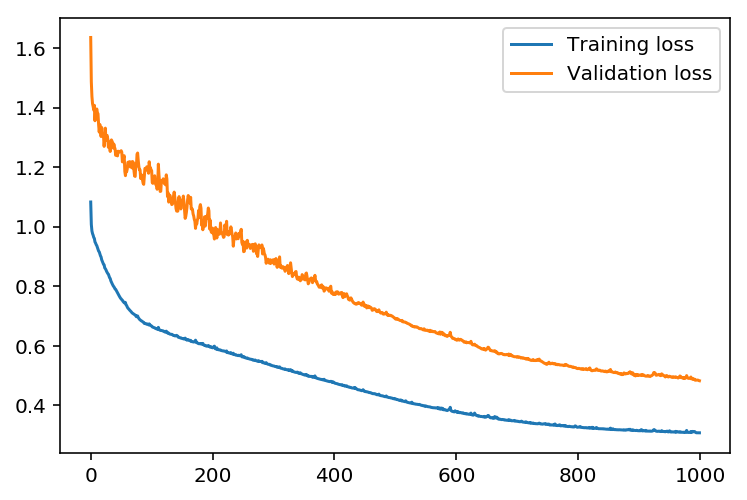

In [36]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Check out your predictions

Here, use the test data to view how well your network is modeling the data. If something is completely wrong here, make sure each step in your network is implemented correctly.

[[ 0.11729277]
 [-0.23955997]
 [-0.5518524 ]
 [-0.36919032]
 [-0.42198657]
 [-0.83146564]
 [-0.6708038 ]
 [-0.73871366]
 [-0.26714709]
 [ 0.5425422 ]
 [ 1.13921573]
 [ 0.44666601]
 [ 0.18229697]
 [ 0.28301384]
 [ 0.42867916]
 [ 0.44990436]
 [ 0.33542625]
 [ 0.40214464]
 [ 0.71977038]
 [ 1.41472069]
 [ 1.25569446]
 [ 0.82357979]
 [ 0.44051129]
 [ 0.17768796]
 [-0.02977601]
 [-0.23681501]
 [-0.37459681]
 [-0.52292863]
 [-0.53806887]
 [-0.64322576]
 [-0.64485381]
 [-0.55105981]
 [-0.30914023]
 [ 0.47368157]
 [ 0.99795517]
 [ 0.36984556]
 [ 0.08999681]
 [ 0.27148969]
 [ 0.52446035]
 [ 0.48168072]
 [ 0.33251843]
 [ 0.39156323]
 [ 0.71147404]
 [ 1.41350108]
 [ 1.29905771]
 [ 0.76838855]
 [ 0.42177778]
 [ 0.14750993]
 [ 0.00300468]
 [-0.31104458]
 [-0.419573  ]
 [-0.44736233]
 [-0.56910972]
 [-0.6102225 ]
 [-0.63575945]
 [-0.51325882]
 [-0.27621619]
 [ 0.43628793]
 [ 1.00475611]
 [ 0.43828079]
 [ 0.21747213]
 [ 0.36814905]
 [ 0.57301973]
 [ 0.58025839]
 [ 0.45306134]
 [ 0.53019663]
 [ 0.77300

/home/leovargas/.conda/envs/meuAmbiente/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


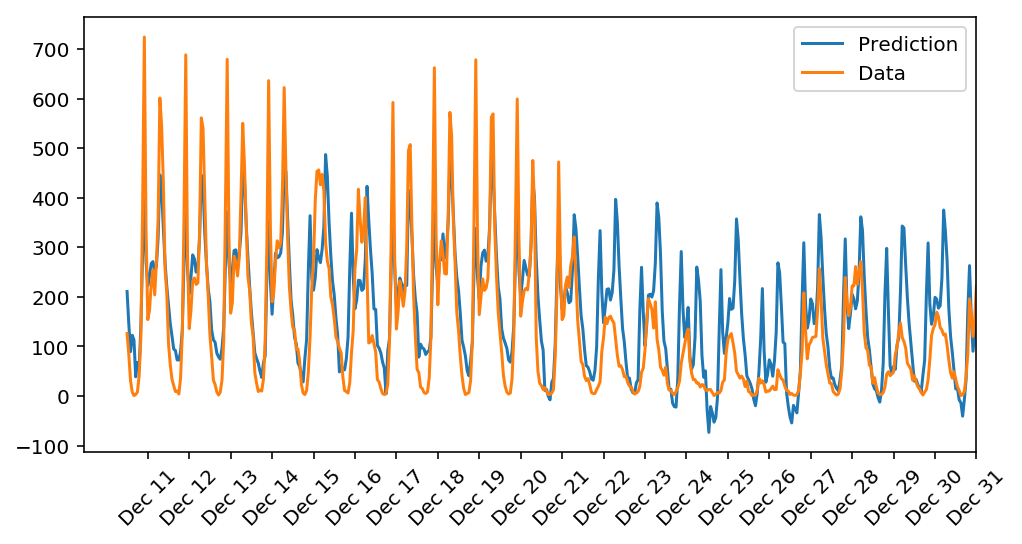

In [37]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## OPTIONAL: Thinking about your results(this question will not be evaluated in the rubric).
 
Answer these questions about your results. How well does the model predict the data? Where does it fail? Why does it fail where it does?

> **Note:** You can edit the text in this cell by double clicking on it. When you want to render the text, press control + enter

#### Your answer below